# Runnning function to convert other geogrpahical unit data into neighborhood level data

In [1]:
# importing all geospatial libraries
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
#importing building permit data to then filter projects built in the last 5 years
#additional column inserted AFFD where NOAH = no affordable housing, and AH = affordable housing, based on work description
newunits = pd.read_csv ("data/AFFD_Building_Permits__New_Housing_Units_AFFD (1).csv")



/tmp/ipykernel_322/1733856514.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  newunits = pd.read_csv ("data/AFFD_Building_Permits__New_Housing_Units_AFFD (1).csv")


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
newunits.head()

Assessor Book Assessor Page Assessor Parcel  \
0         4211.0            27               6   
1         5420.0            15              20   
2         2673.0             6              45   
3         4362.0             3              43   
4         2673.0             6              49   

                                               Tract Block Lot  \
0                                      TR 49104-06-C   NaN  19   
1  BLOCKS NO'S. 11, 12, 13, 14, 15, 16, 17, 18, 1...    21  18   
2                                           TR 74704   NaN   1   
3                                            TR 7656     6   9   
4                                           TR 74704   NaN   5   

  Reference # (Old Permit #)      PCIS Permit #    Permit Type  \
0                  19WL99310  19010-30000-00548       Bldg-New   
1                  21LA01334  19010-10000-06113       Bldg-New   
2                  21ON 2734  18010-20000-01399       Bldg-New   
3                  17VN34261  14010-10001-03040  Bldg-Addition   
4                  21ON 2735  18010-20000-01403       Bldg-New   

          Permit Sub-Type Permit Category  Project Number  Event Code  \
0  1 or 2 Family Dwelling      Plan Check             NaN         NaN   
1  1 or 2 Family Dwelling      Plan Check             NaN         NaN   
2  1 or 2 Family Dwelling      Plan Check             NaN         NaN   
3  1 or 2 Family Dwelling      Plan Check             NaN         NaN   
4  1 or 2 Family Dwelling      Plan Check             NaN         NaN   

  Initiating Office Issue Date  Address Start Address Fraction Start  \
0           WEST LA  5/31/2019           6500                    NaN   
1             METRO  9/30/2021           1950                    NaN   
2          VAN NUYS  1/22/2021          15827                    NaN   
3             METRO   2/1/2017            627                    NaN   
4          VAN NUYS  1/22/2021          15803                    NaN   

   Address End Address Fraction End Street Direction  Street Name  \
0         6500                  NaN                S     SEABLUFF   
1         1950                  NaN                N       VESTAL   
2        15827                  NaN                W         NAPA   
3          627                  NaN                N  CARCASSONNE   
4        15803                  NaN                W         NAPA   

  Street Suffix Suffix Direction Unit Range Start Unit Range End  Zip Code  \
0            DR              NaN              NaN            NaN   90094.0   
1           AVE              NaN              NaN            NaN   90026.0   
2            ST              NaN              NaN            NaN   91343.0   
3          ROAD              NaN              NaN            NaN   90077.0   
4            ST              NaN              NaN            NaN   91343.0   

                                    Work Description  AFFD  Valuation  \
0  Three story single family dwelling with attcah...  NOAH   401000.0   
1  NEW 3-STORY SINGLE FAMILY RESIDENCE - 2389 SQF...  NOAH   298625.0   
2  NEW 34'-0" x 47'-4" TWO-STORY SINGLE FAMILY DW...  NOAH   260000.0   
3  1.) SUPPLEMENTAL TO 14010-30000-03040 FOR CHAN...  NOAH   500000.0   
4  NEW 34'-0" x 47'-6" TWO-STORY SINGLE FAMILY DW...  NOAH   260000.0   

   Floor Area-L.A. Zoning Code Definition  # of Residential Dwelling Units  \
0                                  3664.0                                1   
1                                  2389.0                                1   
2                                  2217.0                                1   
3                                 20381.0                                1   
4                                  2217.0                                1   

   # of Stories Contractor's Business Name    Contractor Address  \
0           3.0              OWNER-BUILDER                   NaN   
1           3.0       TOSTY'S CONSTRUCTION  3455 CATTARAUGUS AVE   
2           2.0              OWNER-BUILD

In [4]:
newunits.shape

(25062, 54)

In [5]:
print(newunits['Permit Type'].unique())

['Bldg-New' 'Bldg-Addition' 'Bldg-Alter/Repair' 'Fire Sprinkler'
 'Bldg-Demolition' 'Grading' 'Bldg-Relocation' 'Plumbing' 'Nonbldg-New'
 'Electrical' 'Elevator' 'HVAC']


In [6]:
#creating  new dataset with trimmed columns
newunits_trimmed = newunits[['Tract','Permit Type','Permit Sub-Type','Issue Date','# of Residential Dwelling Units','AFFD','Zone','Census Tract','Latitude','Longitude']]
newunits_trimmed.head()

Tract    Permit Type  \
0                                      TR 49104-06-C       Bldg-New   
1  BLOCKS NO'S. 11, 12, 13, 14, 15, 16, 17, 18, 1...       Bldg-New   
2                                           TR 74704       Bldg-New   
3                                            TR 7656  Bldg-Addition   
4                                           TR 74704       Bldg-New   

          Permit Sub-Type Issue Date  # of Residential Dwelling Units  AFFD  \
0  1 or 2 Family Dwelling  5/31/2019                                1  NOAH   
1  1 or 2 Family Dwelling  9/30/2021                                1  NOAH   
2  1 or 2 Family Dwelling  1/22/2021                                1  NOAH   
3  1 or 2 Family Dwelling   2/1/2017                                1  NOAH   
4  1 or 2 Family Dwelling  1/22/2021                                1  NOAH   

         Zone  Census Tract  Latitude  Longitude  
0      R4(PV)       2756.02  33.97210 -118.42177  
1     RD2-1VL       1974.10  34.08801 -118.25256  
2  (T)(Q)R1-1       1174.04  34.22664 -118.47725  
3    RE40-1-H       2621.00       NaN        NaN  
4  (T)(Q)R1-1       1174.04  34.22664 -118.47668

In [7]:
#removing all the rows with missing data (NaN)
newunits_trimmed.dropna(subset=['Latitude'], how='all', inplace=True)

/tmp/ipykernel_322/2961966266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newunits_trimmed.dropna(subset=['Latitude'], how='all', inplace=True)


In [8]:
newunits_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19701 entries, 0 to 25061
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Tract                            19636 non-null  object 
 1   Permit Type                      19701 non-null  object 
 2   Permit Sub-Type                  19701 non-null  object 
 3   Issue Date                       19701 non-null  object 
 4   # of Residential Dwelling Units  19701 non-null  int64  
 5   AFFD                             19701 non-null  object 
 6   Zone                             19675 non-null  object 
 7   Census Tract                     19699 non-null  float64
 8   Latitude                         19701 non-null  float64
 9   Longitude                        19701 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 1.7+ MB


In [9]:
#importing shapely files to convert LatLng into a geometry points
from geopandas import GeoDataFrame
from shapely.geometry import Point 
# Shapely for converting latitude/longtitude to geometry

In [10]:
# convert df to gdf
# since data is in lat/lon's assign the crs to WGS84 (epsg:4326)
gdf_newunits = gpd.GeoDataFrame(newunits_trimmed, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(newunits_trimmed.Longitude, newunits_trimmed.Latitude))

In [11]:
gdf_newunits.sample(5)

Tract Permit Type         Permit Sub-Type  \
16661                    P M 2015-4609    Bldg-New  1 or 2 Family Dwelling   
12251                          TR 4849    Bldg-New  1 or 2 Family Dwelling   
24125                  KNOB HILL TRACT    Bldg-New               Apartment   
17484                    P M 2017-2838    Bldg-New  1 or 2 Family Dwelling   
15843  RAFAEL AND ANDRES MACHADO TRACT    Bldg-New  1 or 2 Family Dwelling   

       Issue Date  # of Residential Dwelling Units  AFFD       Zone  \
16661  10/17/2017                                1  NOAH       R1-1   
12251   4/16/2015                                1  NOAH     R2-1XL   
24125   10/3/2014                               29  NOAH       R3-1   
17484   4/12/2021                                1  NOAH       R1-1   
15843   12/9/2014                                1  NOAH  RD1.5-1-O   

       Census Tract  Latitude  Longitude                     geometry  
16661       1395.02  34.15862 -118.52682  POINT (-118.52682 34.15862)  
12251       1920.02  34.08644 -118.35935  POINT (-118.35935 34.08644)  
24125       2088.02  34.06322 -118.27542  POINT (-118.27542 34.06322)  
17484       1278.04  34.19774 -118.45920  POINT (-118.45920 34.19774)  
15843       2739.02  33.98720 -118.46328  POINT (-118.46328 33.98720)

In [12]:
newunits_trimmed['AFFD'].value_counts()

NOAH    19525
AH        176
Name: AFFD, dtype: int64

In [13]:
gdf_units = gdf_newunits.loc[gdf_newunits['Permit Type'].isin(['Bldg-New','Bldg-Addition'])]
gdf_units.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18434 entries, 0 to 25061
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Tract                            18373 non-null  object  
 1   Permit Type                      18434 non-null  object  
 2   Permit Sub-Type                  18434 non-null  object  
 3   Issue Date                       18434 non-null  object  
 4   # of Residential Dwelling Units  18434 non-null  int64   
 5   AFFD                             18434 non-null  object  
 6   Zone                             18414 non-null  object  
 7   Census Tract                     18433 non-null  float64 
 8   Latitude                         18434 non-null  float64 
 9   Longitude                        18434 non-null  float64 
 10  geometry                         18434 non-null  geometry
dtypes: float64(3), geometry(1), int64(1), object(6)
memory usag

In [14]:
gdf_units['Permit Type'].value_counts()

Bldg-New         17573
Bldg-Addition      861
Name: Permit Type, dtype: int64

In [15]:
gdf_units['AFFD'].value_counts()

NOAH    18263
AH        171
Name: AFFD, dtype: int64

In [16]:
gdf_units.sample(10)

Tract Permit Type         Permit Sub-Type  \
14399        LOS TERRENITOS TRACT    Bldg-New  1 or 2 Family Dwelling   
21859                     TR 1000    Bldg-New  1 or 2 Family Dwelling   
5231                      TR 5822    Bldg-New  1 or 2 Family Dwelling   
18756  SHAFER AND LANTERMAN TRACT    Bldg-New  1 or 2 Family Dwelling   
4711                     TR 13306    Bldg-New  1 or 2 Family Dwelling   
21496                     TR 5745    Bldg-New  1 or 2 Family Dwelling   
12475                     TR 9226    Bldg-New  1 or 2 Family Dwelling   
24304            PELLISSIER TRACT    Bldg-New               Apartment   
7006                     TR 73869    Bldg-New  1 or 2 Family Dwelling   
13002                     TR 7378    Bldg-New  1 or 2 Family Dwelling   

       Issue Date  # of Residential Dwelling Units  AFFD         Zone  \
14399  12/18/2013                                1  NOAH     R1-1-RFA   
21859   2/13/2018                                2  NOAH  (T)(Q)RD2-1   
5231     8/6/2014                                1  NOAH         R1-1   
18756    6/6/2019                                2  NOAH    RD1.5-1XL   
4711    1/22/2015                                1  NOAH         R1-1   
21496    9/4/2015                                2  NOAH         R2-1   
12475    8/3/2018                                1  NOAH       RE11-1   
24304   9/25/2019                               39  NOAH         R3-1   
7006    8/22/2019                                1  NOAH  (T)R1-1-RIO   
13002   9/19/2013                                1  NOAH         R1-1   

       Census Tract  Latitude  Longitude                     geometry  
14399       1011.10  34.25843 -118.29007  POINT (-118.29007 34.25843)  
21859       1278.03  34.20093 -118.45312  POINT (-118.45312 34.20093)  
5231        1413.04  34.14857 -118.45104  POINT (-118.45104 34.14857)  
18756       1912.04  34.09420 -118.29726  POINT (-118.29726 34.09420)  
4711        2721.00  34.00566 -118.44104  POINT (-118.44104 34.00566)  
21496       2411.10  33.94113 -118.27105  POINT (-118.27105 33.94113)  
12475       2654.10  34.07116 -118.46711  POINT (-118.46711 34.07116)  
24304       2132.02  34.05068 -118.30482  POINT (-118.30482 34.05068)  
7006        1320.01  34.19193 -118.51074  POINT (-118.51074 34.19193)  
13002       1251.00  34.16295 -118.39122  POINT (-118.39122 34.16295)

In [17]:
gdf_units['All'] = gdf_units.loc[:, 'AFFD']
gdf_units['All'] = 1

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
gdf_units.sample()

Tract Permit Type         Permit Sub-Type  \
19409  MENLO PARK SUBDIVISION NO. 2    Bldg-New  1 or 2 Family Dwelling   

      Issue Date  # of Residential Dwelling Units  AFFD  Zone  Census Tract  \
19409  12/9/2019                                2  NOAH  R2-1        2264.2   

       Latitude  Longitude                     geometry  All  
19409   34.0242 -118.25811  POINT (-118.25811 34.02420)    1

In [19]:
#changing the value of AFFD to use the function below
gdf_units['AFFD'] = gdf_units['AFFD'].replace({'AH': 1})
gdf_units['AFFD'] = gdf_units['AFFD'].replace({'NOAH': 0})
gdf_units.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18434 entries, 0 to 25061
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Tract                            18373 non-null  object  
 1   Permit Type                      18434 non-null  object  
 2   Permit Sub-Type                  18434 non-null  object  
 3   Issue Date                       18434 non-null  object  
 4   # of Residential Dwelling Units  18434 non-null  int64   
 5   AFFD                             18434 non-null  int64   
 6   Zone                             18414 non-null  object  
 7   Census Tract                     18433 non-null  float64 
 8   Latitude                         18434 non-null  float64 
 9   Longitude                        18434 non-null  float64 
 10  geometry                         18434 non-null  geometry
 11  All                              18434 non-null  int64   
d

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
gdf_units.sample(5)

Tract Permit Type  \
23308                      J. D. AND ASA HUNTER PROPERTY    Bldg-New   
23161                                           TR 11994    Bldg-New   
19452                         HUNTINGTON BOULEVARD TRACT    Bldg-New   
21041  THE MC CARTHY COMPANY'S MAIN STREET MONETA AVE...    Bldg-New   
21071                         COMPTON AVENUE VILLA TRACT    Bldg-New   

              Permit Sub-Type  Issue Date  # of Residential Dwelling Units  \
23308              Commercial   3/15/2017                                8   
23161               Apartment    1/9/2014                                7   
19452  1 or 2 Family Dwelling    5/1/2019                                2   
21041  1 or 2 Family Dwelling    5/7/2015                                2   
21071  1 or 2 Family Dwelling  12/12/2017                                2   

       AFFD           Zone  Census Tract  Latitude  Longitude  \
23308     0  [Q]CM-1XL-RIO       1972.00  34.09459 -118.24012   
23161     0        [Q]R3-1       1288.01  34.16751 -118.46576   
19452     0        RD1.5-1       2015.01  34.08890 -118.16660   
21041     0           R2-1       2328.00  33.99410 -118.27623   
21071     0        [Q]C2-1       2287.20  33.99621 -118.24802   

                          geometry  All  
23308  POINT (-118.24012 34.09459)    1  
23161  POINT (-118.46576 34.16751)    1  
19452  POINT (-118.16660 34.08890)    1  
21041  POINT (-118.27623 33.99410)    1  
21071  POINT (-118.24802 33.99621)    1

# Spatial Autocorrelation using AH data on a census tract level

In [21]:
#to find number of ah per census tract and get census boundaries, we import census data
gdf_tracts = gpd.read_file('data/tracts.geojson')


In [22]:
gdf_tracts.shape

(1005, 5)

In [23]:
gdf_tracts.sample(5)

geoid                                   name  B01003001  \
691   14000US06037222700     Census Tract 2227, Los Angeles, CA     4071.0   
1003  14000US06037990200     Census Tract 9902, Los Angeles, CA        0.0   
984   14000US06037297500     Census Tract 2975, Los Angeles, CA     4707.0   
593   14000US06037211910  Census Tract 2119.10, Los Angeles, CA     4371.0   
91    14000US06037113232  Census Tract 1132.32, Los Angeles, CA     4315.0   

      B01003001, Error                                           geometry  
691              366.0  MULTIPOLYGON (((-118.29154 34.02550, -118.2912...  
1003              12.0  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
984              440.0  MULTIPOLYGON (((-118.31142 33.71384, -118.3111...  
593              536.0  MULTIPOLYGON (((-118.30036 34.06720, -118.3003...  
91               372.0  MULTIPOLYGON (((-118.62539 34.22633, -118.6252...

In [24]:
#editing the name column in census tract to allow merging later
gdf_tracts['CT'] = gdf_tracts['name'].str.split(' ').str[2]

In [25]:
gdf_tracts['CT']=gdf_tracts['CT'].str.replace(',','')

In [26]:
gdf_tracts.sample(5)

geoid                                   name  B01003001  \
311  14000US06037137502  Census Tract 1375.02, Los Angeles, CA     4549.0   
236  14000US06037128210  Census Tract 1282.10, Los Angeles, CA     5008.0   
463  14000US06037195201  Census Tract 1952.01, Los Angeles, CA     3128.0   
693  14000US06037224020  Census Tract 2240.20, Los Angeles, CA     2733.0   
788  14000US06037239330  Census Tract 2393.30, Los Angeles, CA     2458.0   

     B01003001, Error                                           geometry  \
311             390.0  MULTIPOLYGON (((-118.60584 34.16597, -118.6057...   
236             429.0  MULTIPOLYGON (((-118.44872 34.18666, -118.4465...   
463             204.0  MULTIPOLYGON (((-118.28524 34.10933, -118.2852...   
693             294.0  MULTIPOLYGON (((-118.27450 34.03296, -118.2744...   
788             286.0  MULTIPOLYGON (((-118.26955 33.98244, -118.2683...   

          CT  
311  1375.02  
236  1282.10  
463  1952.01  
693  2240.20  
788  2393.30

In [27]:
gdf_tracts = gdf_tracts[['geometry','CT']]

In [28]:
gdf_tracts.drop(gdf_tracts.loc[gdf_tracts['CT']=='CA'].index, inplace=True)

In [29]:
gdf_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1004 non-null   geometry
 1   CT        1004 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 15.8+ KB


In [30]:
gdf_tracts["CT"] = gdf_tracts.CT.astype(float)

In [31]:
AH = gdf_units[['Census Tract','AFFD','geometry']]

In [32]:
AH.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18434 entries, 0 to 25061
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Census Tract  18433 non-null  float64 
 1   AFFD          18434 non-null  int64   
 2   geometry      18434 non-null  geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 576.1 KB


In [33]:
AH_dis = AH.dissolve(by = ['Census Tract'], aggfunc = 'sum')
AH_dis['AFFD'].unique()

array([0, 3, 2, 1, 4])

In [34]:
AH_dis.shape

(926, 2)

In [35]:
AH_dis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Float64Index: 926 entries, 1011.1 to 9800.15
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  926 non-null    geometry
 1   AFFD      926 non-null    int64   
dtypes: geometry(1), int64(1)
memory usage: 54.0 KB


In [36]:
AH_dis.reset_index(inplace = True)

In [37]:
AH_trim = AH_dis[['Census Tract','AFFD']]

In [38]:
AH_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Census Tract  926 non-null    float64
 1   AFFD          926 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 14.6 KB


In [39]:
#changing column name to merge
AH_trim.columns = ['CT', 'AFFD']

In [40]:
AH_trim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CT      926 non-null    float64
 1   AFFD    926 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 14.6 KB


In [41]:
AH_ct = gdf_tracts.merge(AH_trim,on="CT")

In [42]:
AH_ct.sample(5)

geometry       CT  AFFD
817  MULTIPOLYGON (((-118.41693 34.03171, -118.4166...  2699.04     0
708  MULTIPOLYGON (((-118.29807 33.97540, -118.2980...  2374.01     0
618  MULTIPOLYGON (((-118.30075 34.04248, -118.3007...  2212.20     1
532  MULTIPOLYGON (((-118.29169 34.07633, -118.2905...  2111.22     0
258  MULTIPOLYGON (((-118.66780 34.20696, -118.6678...  1344.24     0

In [43]:
AH_ct = AH_ct.to_crs(epsg=3857)

## IGNORE FROM HERE

In [44]:
#to find number of ah per census tract and get census boundaries, we do a spatial join
# Do the spatial join
join = gpd.sjoin(gdf_tracts, AH_dis, how='left')

In [45]:
join.shape

(1032, 5)

In [46]:
join.sample(5)

geometry       CT  index_right  \
232  MULTIPOLYGON (((-118.44876 34.20119, -118.4477...  1279.10        212.0   
974  MULTIPOLYGON (((-118.29675 33.73607, -118.2967...  2966.00        910.0   
374  MULTIPOLYGON (((-118.20290 34.10275, -118.2028...  1838.20        341.0   
185  MULTIPOLYGON (((-118.43125 34.18667, -118.4290...  1236.02        165.0   
714  MULTIPOLYGON (((-118.27400 34.01113, -118.2728...  2284.20        660.0   

     Census Tract  AFFD  
232       1279.10   0.0  
974       2966.00   1.0  
374       1838.20   0.0  
185       1236.02   1.0  
714       2284.20   0.0

In [47]:
join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1032 entries, 0 to 1003
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      1032 non-null   geometry
 1   CT            1032 non-null   float64 
 2   index_right   949 non-null    float64 
 3   Census Tract  949 non-null    float64 
 4   AFFD          949 non-null    float64 
dtypes: float64(4), geometry(1)
memory usage: 48.4 KB


In [48]:
join = join[join['Census Tract'].notna()]

In [49]:
join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 949 entries, 0 to 993
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      949 non-null    geometry
 1   CT            949 non-null    float64 
 2   index_right   949 non-null    float64 
 3   Census Tract  949 non-null    float64 
 4   AFFD          949 non-null    float64 
dtypes: float64(4), geometry(1)
memory usage: 44.5 KB


In [50]:
join.sample(5)

geometry       CT  index_right  \
159  MULTIPOLYGON (((-118.39652 34.21572, -118.3944...  1218.01        139.0   
386  MULTIPOLYGON (((-118.23654 34.11316, -118.2365...  1863.02        354.0   
684  MULTIPOLYGON (((-118.29590 34.02716, -118.2959...  2219.00        635.0   
147  MULTIPOLYGON (((-118.45976 34.22481, -118.4596...  1201.07        128.0   
742  MULTIPOLYGON (((-118.31713 33.99044, -118.3171...  2325.00        688.0   

     Census Tract  AFFD  
159       1218.01   0.0  
386       1863.02   0.0  
684       2219.00   0.0  
147       1201.07   0.0  
742       2325.00   0.0

In [51]:
join_sc= join[['geometry','CT','AFFD']]

In [52]:
join_sc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 949 entries, 0 to 993
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  949 non-null    geometry
 1   CT        949 non-null    float64 
 2   AFFD      949 non-null    float64 
dtypes: float64(2), geometry(1)
memory usage: 29.7 KB


<AxesSubplot: >

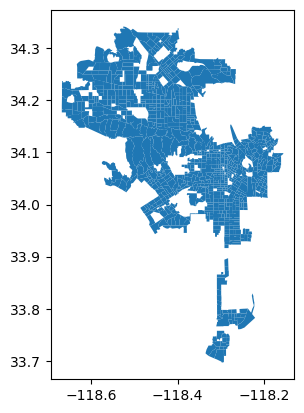

In [53]:
join_sc.plot()

In [54]:
join_sc.tail(10)

geometry       CT  AFFD
979  MULTIPOLYGON (((-118.28798 33.72299, -118.2879...  2971.20   0.0
980  MULTIPOLYGON (((-118.29461 33.72245, -118.2946...  2972.01   0.0
981  MULTIPOLYGON (((-118.30343 33.72248, -118.3034...  2972.02   0.0
982  MULTIPOLYGON (((-118.32118 33.71756, -118.3204...  2973.00   0.0
983  MULTIPOLYGON (((-118.33491 33.71662, -118.3330...  2974.00   0.0
984  MULTIPOLYGON (((-118.31142 33.71384, -118.3111...  2975.00   0.0
986  MULTIPOLYGON (((-118.29286 33.72110, -118.2928...  2976.02   0.0
987  MULTIPOLYGON (((-118.46889 34.06587, -118.4687...  7011.00   0.0
992  MULTIPOLYGON (((-118.26088 33.76850, -118.2602...  9800.14   1.0
993  MULTIPOLYGON (((-118.31048 33.76685, -118.3102...  9800.15   0.0

In [55]:
join_sc = join_sc.to_crs(epsg=3857)

In [56]:
join_sc.head()

geometry       CT  AFFD
0  MULTIPOLYGON (((-13169350.794 4063591.834, -13...  1011.10   0.0
1  MULTIPOLYGON (((-13169467.902 4065613.937, -13...  1011.22   0.0
2  MULTIPOLYGON (((-13169034.646 4063225.625, -13...  1012.10   3.0
3  MULTIPOLYGON (((-13167528.939 4062726.771, -13...  1012.20   0.0
4  MULTIPOLYGON (((-13166671.668 4062511.964, -13...  1013.00   0.0

## IGNORE TILL HERE

In [57]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(AH_ct, k=8)

# Row-standardization
wq.transform = 'r'

/opt/conda/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [58]:
# create a new column for the spatial lag
AH_ct['AH_lag'] = lps.weights.lag_spatial(wq, AH_ct['AFFD'])
AH_ct.sample(5)

geometry       CT  AFFD  AH_lag
75   MULTIPOLYGON (((-13200247.852 4065284.978, -13...  1131.02     0   0.000
592  MULTIPOLYGON (((-13175797.862 4034949.342, -13...  2171.00     0   0.000
208  MULTIPOLYGON (((-13186624.017 4055832.740, -13...  1278.03     0   0.125
148  MULTIPOLYGON (((-13178867.386 4055642.559, -13...  1224.20     0   0.125
704  MULTIPOLYGON (((-13167658.849 4027341.470, -13...  2371.02     0   0.250

# The donut and diamond

In [59]:
# create a column that calculates the difference between AH and lag
AH_ct['AH_lag_diff'] = AH_ct['AFFD'] - AH_ct['AH_lag']

In [60]:
AH_ct.sort_values(by='AH_lag_diff').sample(5)

geometry       CT  AFFD  AH_lag  \
336  MULTIPOLYGON (((-13157349.662 4044377.487, -13...  1836.20     0   0.000   
825  MULTIPOLYGON (((-13186124.749 4032563.839, -13...  2712.00     1   0.125   
124  MULTIPOLYGON (((-13186188.757 4059493.238, -13...  1201.03     0   0.000   
564  MULTIPOLYGON (((-13172068.437 4035224.893, -13...  2129.00     0   0.375   
704  MULTIPOLYGON (((-13167658.849 4027341.470, -13...  2371.02     0   0.250   

     AH_lag_diff  
336        0.000  
825        0.875  
124        0.000  
564       -0.375  
704       -0.250

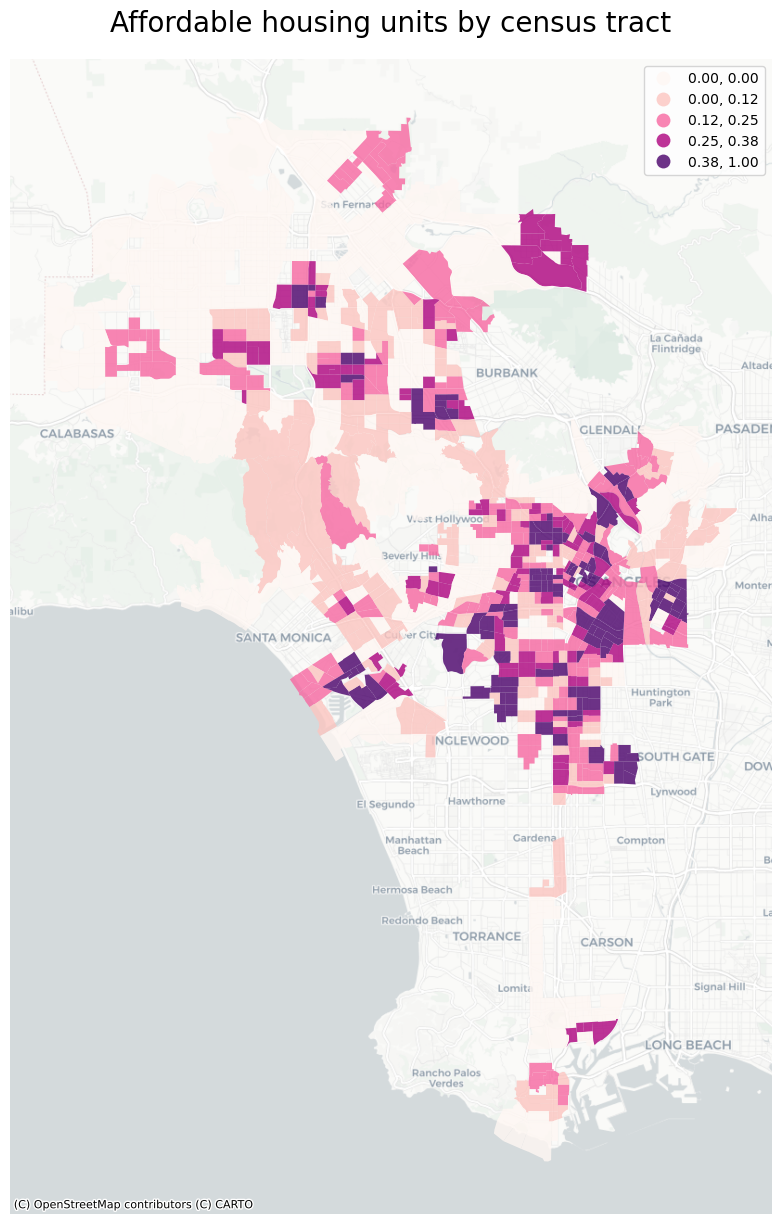

In [61]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
AH_ct.plot(ax=ax,
         figsize=(15,15),
         column='AH_lag',
         legend=True,
         alpha=0.8,
         cmap='RdPu',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Affordable housing units by census tract',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Moran's plot

In [62]:
y = AH_ct.AFFD
moran = Moran(y, wq)
moran.I

0.03846136636179771

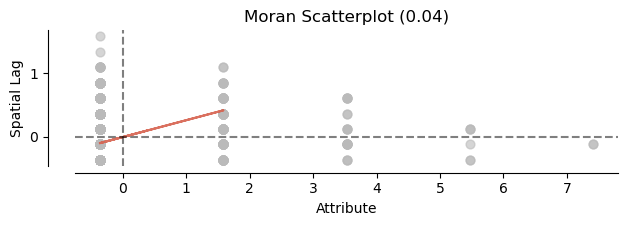

In [63]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.04', ylabel='Density'>)

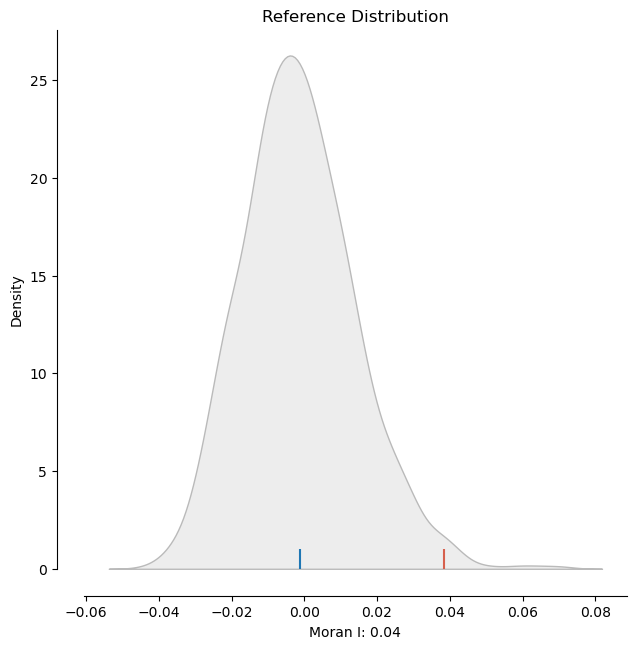

In [64]:
plot_moran_simulation(moran,aspect_equal=False)

In [65]:
moran.p_sim

0.011

## Moran's Local Scatterplot

In [66]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

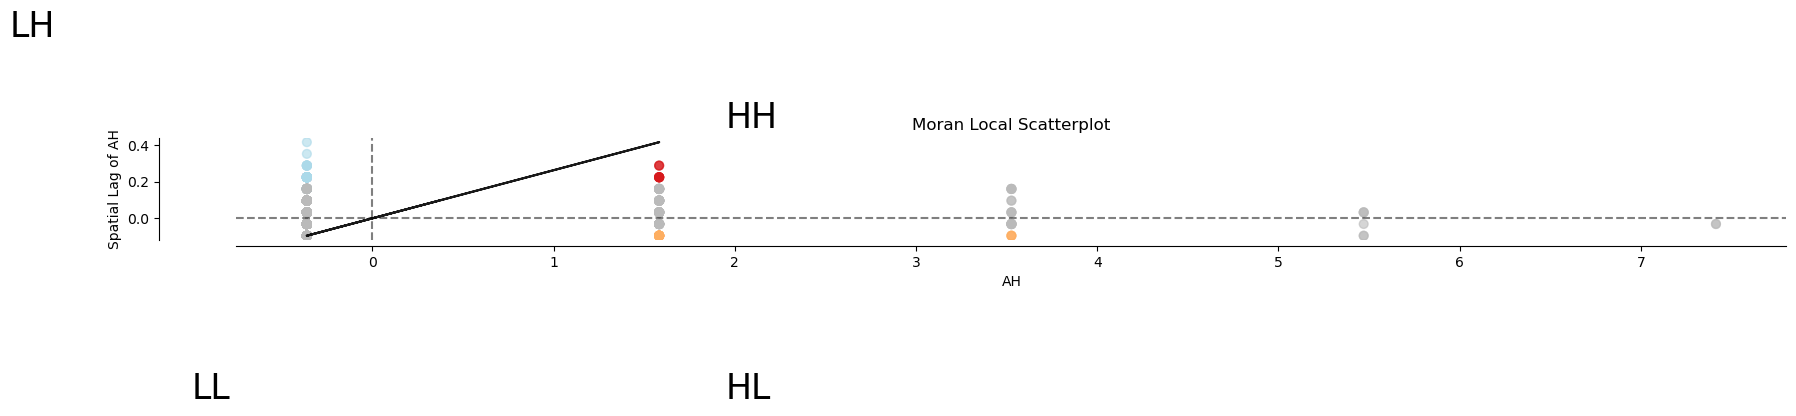

In [67]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("AH")
ax.set_ylabel('Spatial Lag of AH')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

## Spatial Autocorrelation Map

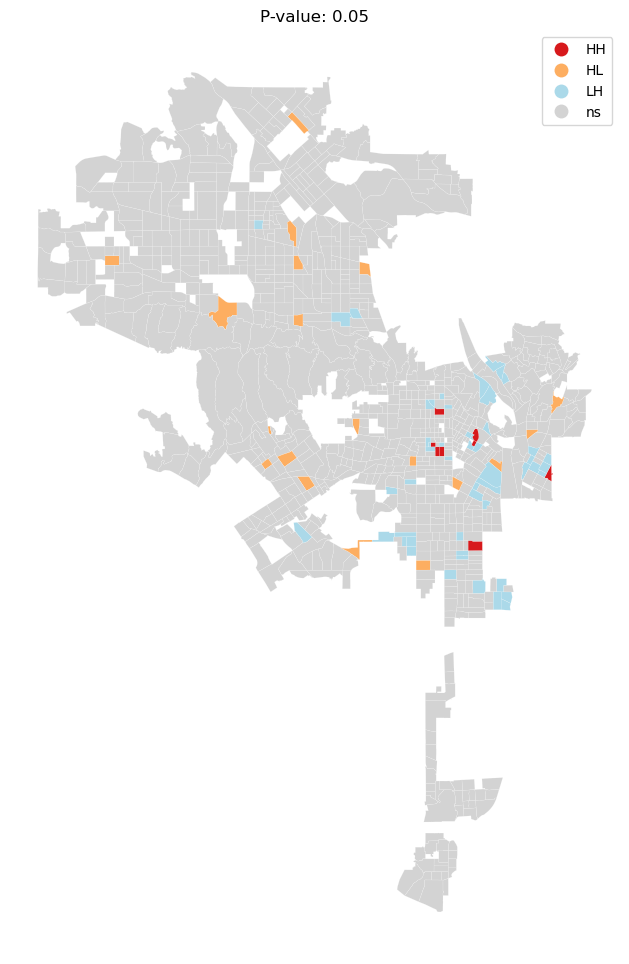

In [68]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, AH_ct, p=0.05, ax=ax)
ax.axis("off")
ax.set_title("P-value: 0.05")
plt.show()


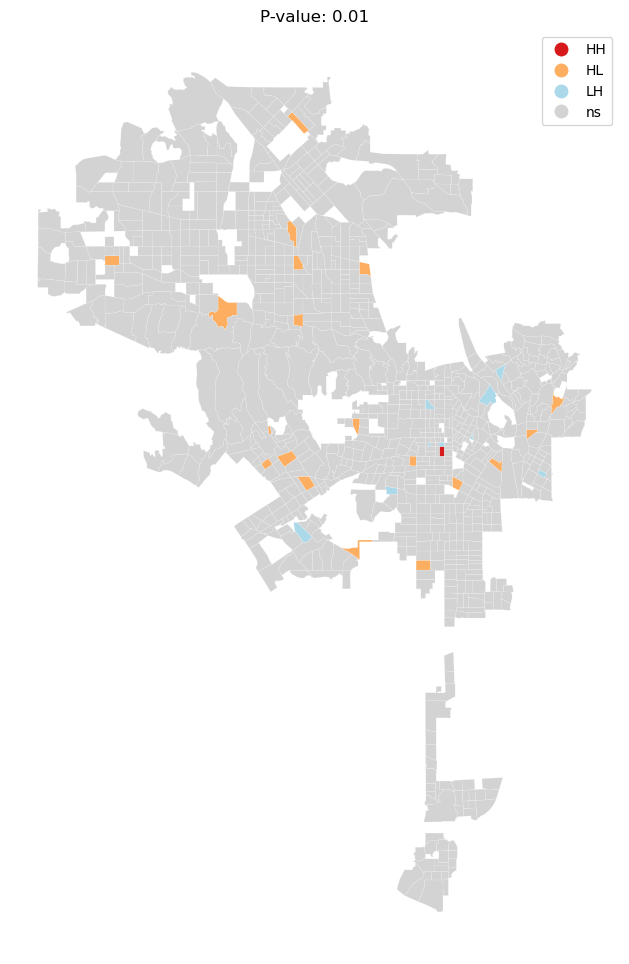

In [69]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, AH_ct, p=0.01, ax=ax)
ax.axis("off")
ax.set_title("P-value: 0.01")
plt.show()

# Making graphs based on affordable housing projects in neighborhoods

In [70]:
#Census Tract To Neighborhood Function
#It takes census tract level geospatial data and dissolves it into neighborhood shapes. 
#The arguments you need are your data frame (i.e. 'df= your data frame', your geometry column, usually named 'geometry' (i.e. "geometry='geometry'", and lastly how you want the variables to be summarized (i.e. 'sum' to add or 'mean' for an average)

def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)
    
    
    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata

In [71]:
# Step 2- plug it into the function 
gdf_units= nhdissolve(df=gdf_units,geometry='geometry',math='sum',skip=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [72]:
gdf_units.sample(10)

geometry  \
Neighborhood                                                              
Cheviot Hills         MULTIPOINT (-118.42289 34.04171, -118.42148 34...   
Carthay               MULTIPOINT (-118.37483 34.05626, -118.37237 34...   
Atwater Village       MULTIPOINT (-118.27003 34.13240, -118.26900 34...   
Hollywood Hills West  MULTIPOINT (-118.39524 34.09556, -118.39521 34...   
Vermont Vista         MULTIPOINT (-118.29142 33.93837, -118.29141 33...   
Porter Ranch          MULTIPOINT (-118.56406 34.28072, -118.53841 34...   
Elysian Park          MULTIPOINT (-118.23695 34.06733, -118.23573 34...   
Leimert Park          MULTIPOINT (-118.33460 34.00701, -118.33443 34...   
Broadway-Manchester   MULTIPOINT (-118.28025 33.92412, -118.28017 33...   
Montecito Heights     MULTIPOINT (-118.21169 34.08047, -118.21169 34...   

                      # of Residential Dwelling Units  AFFD  Census Tract  \
Neighborhood                                                                
Cheviot Hills                                     152     0     401011.00   
Carthay                                           251     0      10840.00   
Atwater Village                                    55     0      99383.43   
Hollywood Hills West                              241     0     448108.04   
Vermont Vista                                     281     1     279162.19   
Porter Ranch                                        4     0       4356.13   
Elysian Park                                       15     0      12360.60   
Leimert Park                                      299     0      13901.20   
Broadway-Manchester                               647     2     568239.07   
Montecito Heights                                 124     1     145054.60   

                        Latitude    Longitude  All  
Neighborhood                                        
Cheviot Hills         5071.66970 -17642.91557  149  
Carthay                170.27413   -591.85307    5  
Atwater Village       1808.36135  -6267.78476   53  
Hollywood Hills West  7809.71573 -27108.49110  229  
Vermont Vista         3971.74676 -13839.43198  117  
Porter Ranch           137.12283   -474.16524    4  
Elysian Park           204.45249   -709.40491    6  
Leimert Park           204.07116   -709.97767    6  
Broadway-Manchester   8010.28014 -27912.62974  236  
Montecito Heights     2522.59369  -8746.45892   74

In [73]:
#setting the name of the first column to be neighborhood
gdf_units.index

Index(['Adams-Normandie', 'Arleta', 'Arlington Heights', 'Atwater Village',
       'Baldwin Hills/Crenshaw', 'Bel-Air', 'Beverly Crest', 'Beverly Grove',
       'Beverlywood', 'Boyle Heights',
       ...
       'West Adams', 'West Hills', 'West Los Angeles', 'Westchester',
       'Westlake', 'Westwood', 'Wilmington', 'Windsor Square', 'Winnetka',
       'Woodland Hills'],
      dtype='object', name='Neighborhood', length=111)

In [74]:
gdf_units.reset_index(inplace = True)

In [75]:
gdf_units.sample()

Neighborhood                                           geometry  \
26    Echo Park  MULTIPOINT (-118.27293 34.07575, -118.27239 34...   

    # of Residential Dwelling Units  AFFD  Census Tract     Latitude  \
26                             1401     4     595466.58  10292.12044   

      Longitude  All  
26 -35713.38401  302

In [76]:
#importing neighborhood data
# converting the data to a neighborhood scale
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

In [77]:
neighborhoods.sample(5)

OBJECTID              name  \
86         87       Studio City   
64         65  Mount Washington   
8           9       Beverlywood   
90         91           Tarzana   
111       112          Winnetka   

                                              geometry  
86   POLYGON ((-118.40343 34.15663, -118.40275 34.1...  
64   POLYGON ((-118.21356 34.11627, -118.21207 34.1...  
8    POLYGON ((-118.38609 34.04675, -118.38934 34.0...  
90   POLYGON ((-118.52729 34.17083, -118.52724 34.1...  
111  POLYGON ((-118.56232 34.23199, -118.56232 34.2...

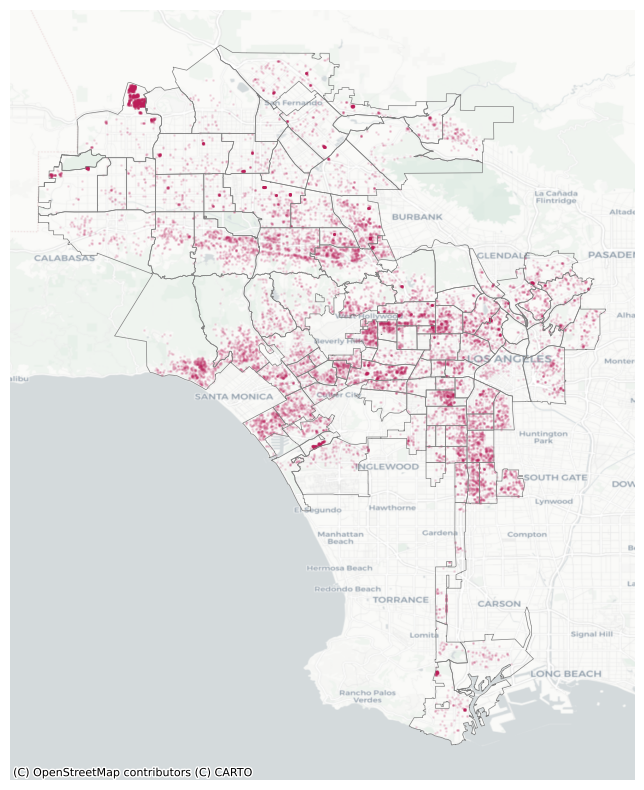

In [78]:
# map it!
fig,ax = plt.subplots(figsize=(10,10))

gdf_units.plot(ax=ax,
             color='#bc1d59ff',
             markersize=1, alpha=0.1)

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'grey',
            linewidth = 0.5,
            )

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,crs=4326,source=ctx.providers.CartoDB.Positron)

In [79]:
gdf_units.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Neighborhood                     111 non-null    object  
 1   geometry                         111 non-null    geometry
 2   # of Residential Dwelling Units  111 non-null    int64   
 3   AFFD                             111 non-null    int64   
 4   Census Tract                     111 non-null    float64 
 5   Latitude                         111 non-null    float64 
 6   Longitude                        111 non-null    float64 
 7   All                              111 non-null    int64   
dtypes: float64(3), geometry(1), int64(3), object(1)
memory usage: 7.1+ KB


In [80]:
gdf_sorted= gdf_units.sort_values('AFFD',ascending=False)

In [81]:
gdf_sorted.head(20)

Neighborhood  \
105                Westlake   
25           East Hollywood   
50                Koreatown   
9             Boyle Heights   
22                  Del Rey   
65          North Hollywood   
97           Vermont Square   
33                 Florence   
100                   Watts   
48                Hyde Park   
26                Echo Park   
49           Jefferson Park   
64              North Hills   
72               Pico-Union   
45                Hollywood   
44   Historic South-Central   
71           Pico-Robertson   
23                 Downtown   
34            Glassell Park   
92              Valley Glen   

                                              geometry  \
105  MULTIPOINT (-118.28782 34.05886, -118.28778 34...   
25   MULTIPOINT (-118.30830 34.08461, -118.30816 34...   
50   MULTIPOINT (-118.32202 34.05612, -118.32184 34...   
9    MULTIPOINT (-118.22167 34.04613, -118.22106 34...   
22   MULTIPOINT (-118.44621 33.98981, -118.44380 33...   
65   MULTIPOINT (-118.39858 34.19748, -118.39788 34...   
97   MULTIPOINT (-118.31621 34.00284, -118.31588 34...   
33   MULTIPOINT (-118.28016 33.96516, -118.28004 33...   
100  MULTIPOINT (-118.25406 33.93064, -118.25209 33...   
48   MULTIPOINT (-118.34995 33.98362, -118.34141 33...   
26   MULTIPOINT (-118.27293 34.07575, -118.27239 34...   
49   MULTIPOINT (-118.33405 34.02885, -118.33394 34...   
64   MULTIPOINT (-118.50217 34.25325, -118.49414 34...   
72   MULTIPOINT (-118.30013 34.03871, -118.30004 34...   
45   MULTIPOINT (-118.36135 34.09598, -118.36135 34...   
44   MULTIPOINT (-118.28000 34.00842, -118.27967 34...   
71   MULTIPOINT (-118.40576 34.05378, -118.40537 34...   
23   MULTIPOINT (-118.26937 34.03815, -118.26900 34...   
34   MULTIPOINT (-118.24274 34.11926, -118.24230 34...   
92   MULTIPOINT (-118.43985 34.18547, -118.43981 34...   

     # of Residential Dwelling Units  AFFD  Census Tract     Latitude  \
105                             6112    11     361275.87   5927.53572   
25                              2504    10     638897.07  11350.69834   
50                              7062     9     290667.11   4666.57420   
9                               1226     8     451319.98   7523.03521   
22                              1170     6     404681.48   4996.95437   
65                              4462     6     644933.51  17702.22483   
97                               561     6     361966.70   5304.32675   
33                              1180     6     931773.82  13215.11116   
100                              681     5     441491.00   6177.21068   
48                               731     5     163965.95   2378.89193   
26                              1401     4     595466.58  10292.12044   
49                               170     4      61408.30    952.80003   
64                               614     4     155650.85   4552.70604   
72                              1274     4     288947.56   4528.06392   
45                              6816     4     953278.26  17012.27412   
44                              1014     4     443611.88   6632.95730   
71                               570     3     234263.23   3473.35472   
23                             20463     3     155312.63   2519.28531   
34                               397     3     193806.79   3548.08113   
92                               803     3     249573.64   6837.00982   

       Longitude  All  
105 -20579.75359  174  
25  -39393.80436  333  
50  -16207.67899  137  
9   -26123.14962  221  
22  -17407.82279  147  
65  -61317.77644  518  
97  -18453.84903  156  
33  -46006.58217  389  
100 -21519.85485  182  
48   -8283.07945   70  
26  -35713.38401  302  
49   -3313.23457   28  
64  -15757.23827  133  
72  -15732.71041  133  
45  -59047.26531  499  
44  -23061.77952  195  
71  -12075.39845  102  
23   -8750.90647   74  
34  -12296.40018  104  
92  -23684.04396  200

<AxesSubplot: xlabel='Neighborhood'>

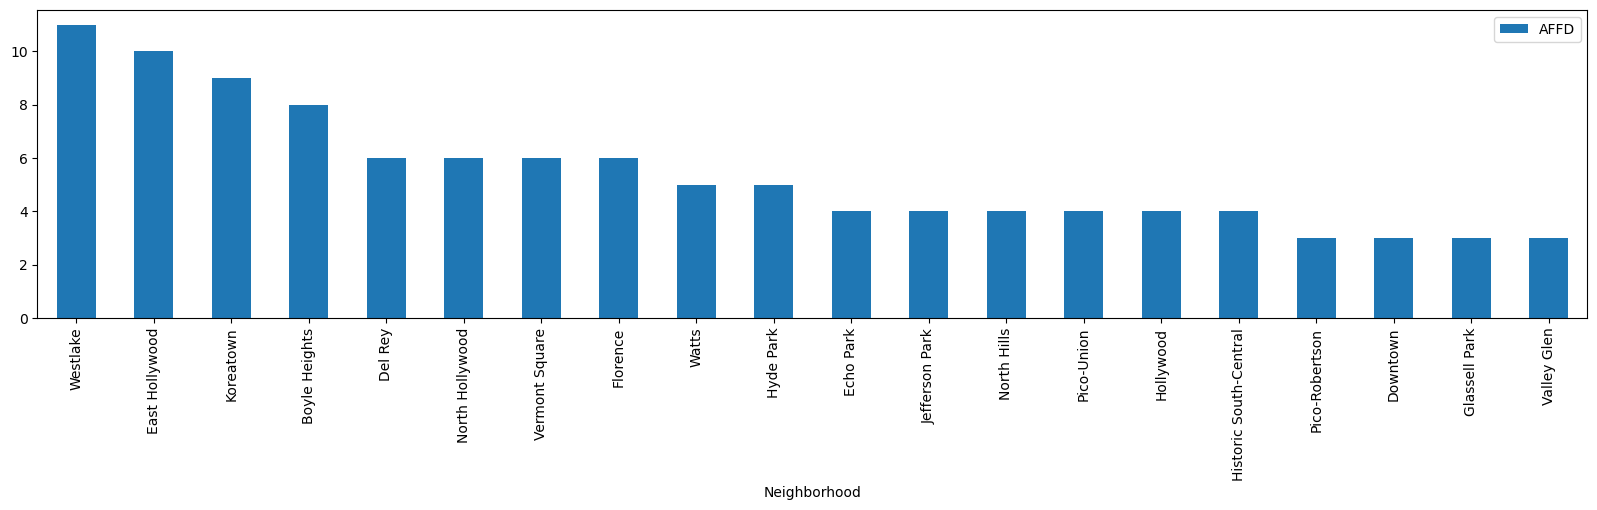

In [82]:
# make a bar chart of top 20 neighborhoods with AH
gdf_sorted[:20].plot.bar(figsize=(20,4),
                         x = 'Neighborhood',   
                         y='AFFD',
           )


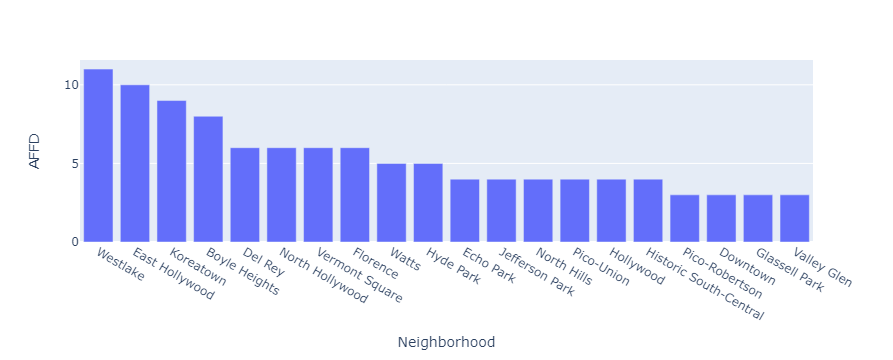

In [83]:
# make a stacked bar chart of the number of affordable housing projects built per neighborhood
import plotly.express as px
fig = px.bar(gdf_sorted[:20],
               x = 'Neighborhood',
             y='AFFD',
      
        labels={
            'name':'Neighborhoods in the City of Los Angeles',
        }
)

fig.show()

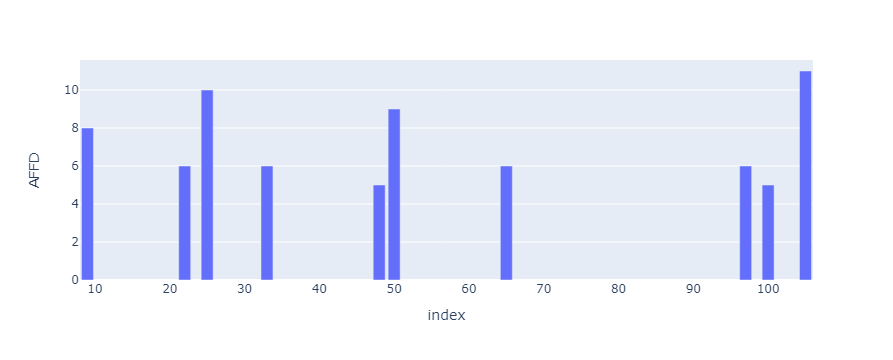

In [67]:
# make a stacked bar chart of the number of affordable housing projects built per neighborhood
import plotly.express as px
fig = px.bar(gdf_sorted[:10],
       y='AFFD',
      
        labels={
            'name':'Neighborhoods in the City of Los Angeles',
            'count':'No. of AH units built after 2015'
        }
)

fig.show()

In [68]:
#creating  new dataset with only neighborhoods and AFFH
gdf_AH = gdf_sorted[['Neighborhood','AFFD','geometry']]
gdf_AH.head()

Neighborhood  AFFD                                           geometry
105        Westlake    11  MULTIPOINT (-118.28782 34.05886, -118.28778 34...
25   East Hollywood    10  MULTIPOINT (-118.30830 34.08461, -118.30816 34...
50        Koreatown     9  MULTIPOINT (-118.32202 34.05612, -118.32184 34...
9     Boyle Heights     8  MULTIPOINT (-118.22167 34.04613, -118.22106 34...
22          Del Rey     6  MULTIPOINT (-118.44621 33.98981, -118.44380 33...

/opt/conda/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).



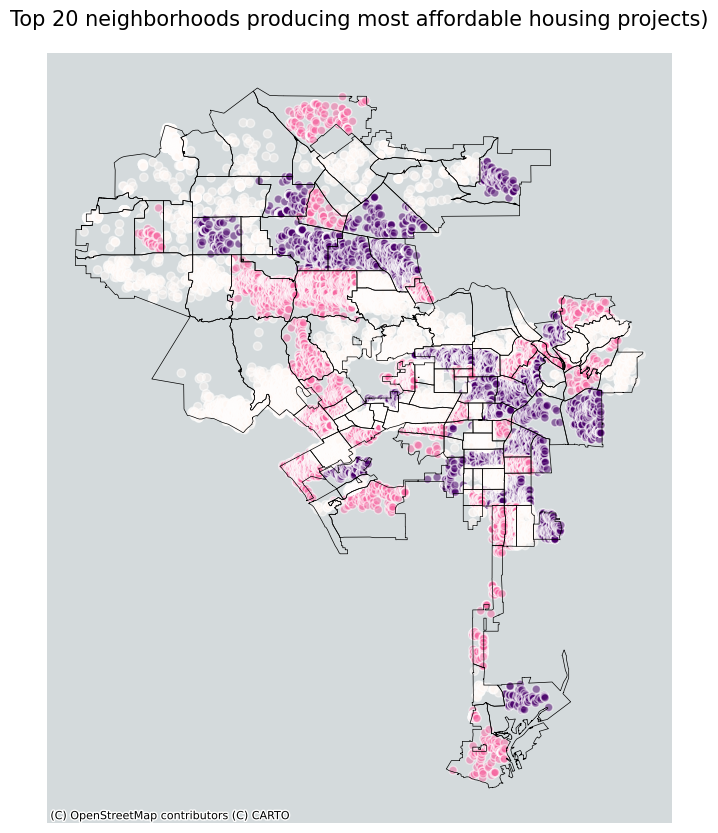

In [70]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf_AH.plot(ax=ax,
                     column = 'AFFD',                                           
                     cmap ='RdPu',
                    scheme='quantiles',
                    k=3,
                    edgecolor='white',
                    alpha=0.5)

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# title
ax.set_title('Top 20 neighborhoods producing most affordable housing projects)',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [71]:
#changing name of a column due to same column names
gdf_AH.columns = gdf_AH.columns.str.replace ('geometry','GEOMETRY')
gdf_AH.sample()

Neighborhood  AFFD                                           GEOMETRY
16   Chatsworth     0  MULTIPOINT (-118.62535 34.24853, -118.62457 34...

In [72]:
#spatial join with neighborhood data to get chotopleth map of AH distribution by neighborhood
gdf_AH_nb = gpd.sjoin(gdf_AH, neighborhoods) #Spatial join 
gdf_AH_nb.sample(5)

AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

In [ ]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
gdf_AH.plot(ax=ax,
                     column = 'AFFD',                                           
                     cmap ='RdPu',
                    scheme='quantiles',
                    k=3,
                    edgecolor='white',
                    alpha=0.5)

neighborhoods.plot(
            ax=ax,                
            color = "none",        
            edgecolor = 'black',
            linewidth = 0.5,
            )

# title
ax.set_title('Top 20 neighborhoods producing most affordable housing projects)',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)